Import important library and load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/content/LoanApprovalPrediction.csv')
print(data.head())

    Loan_ID Gender Married  Dependents     Education Self_Employed  \
0  LP001002   Male      No         0.0      Graduate            No   
1  LP001003   Male     Yes         1.0      Graduate            No   
2  LP001005   Male     Yes         0.0      Graduate           Yes   
3  LP001006   Male     Yes         0.0  Not Graduate            No   
4  LP001008   Male      No         0.0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             

Data Preprocessing and Visualization.

In [3]:
cat_data = (data.dtypes == 'object')
# print("Categorical varibles: ", len(list(cat_data[cat_data].index)))
print("Categorical varibles are: ")
print(cat_data[cat_data].index)


Categorical varibles are: 
Index(['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')


We have a total of 7 categorical columns.


In [4]:
data.drop(['Loan_ID'], axis=1, inplace=True)    #dropping loan_id col

We are assuming Loan_ID do not provide any meaningful insights for data analysis or prediction so we are dropping it.

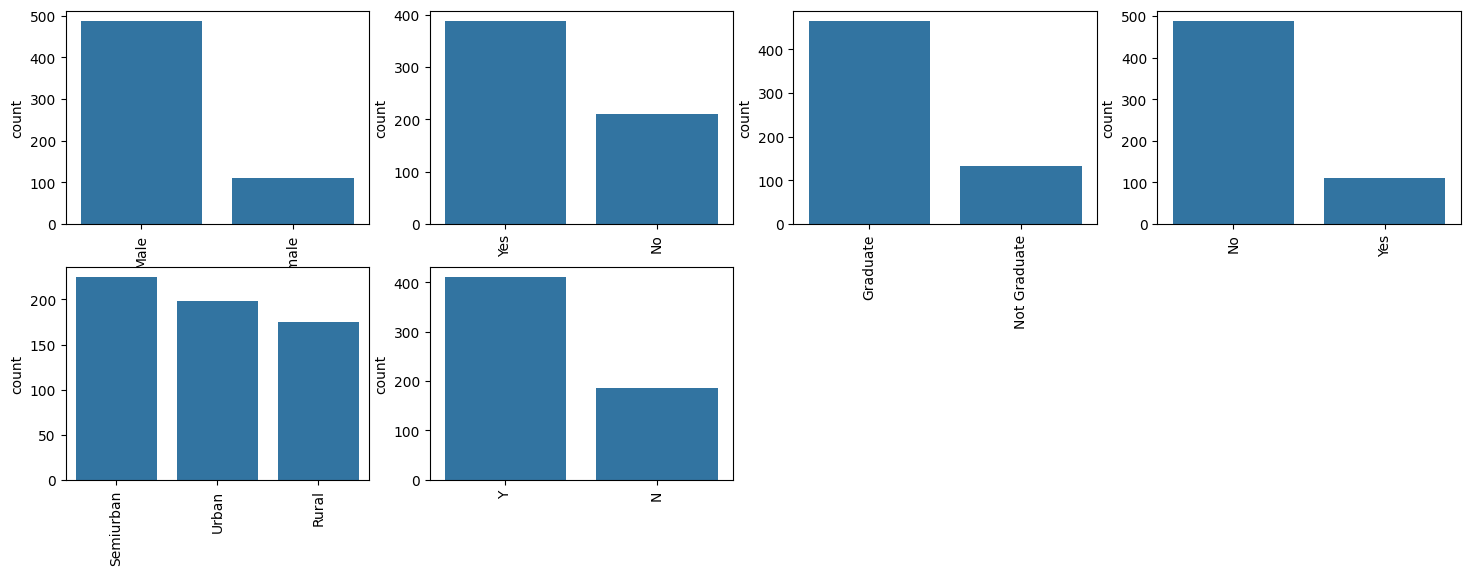

In [5]:
cat_data = (data.dtypes =='object')
cat_cols = list(cat_data[cat_data].index)    #contains all col names of categorical columns
plt.figure(figsize=(18,36))
index = 1

for col in cat_cols:
  y = data[col].value_counts()
  plt.subplot(11,4,index)
  plt.xticks(rotation=90)
  sns.barplot(x=list(y.index), y=y)
  index += 1

All the categorical vlues are in binary so we can use either label encoder or dummy variables.

In [6]:
from sklearn.preprocessing import LabelEncoder   #importing label encoder

LE = LabelEncoder()     # defining lalbel encoder

for col in cat_cols:
  data[col] = LE.fit_transform(data[col])    # Each col will be changed and contain numerical data

print(data.head())

   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        0         0.0          0              0             5849   
1       1        1         1.0          0              0             4583   
2       1        1         0.0          0              1             3000   
3       1        1         0.0          1              0             2583   
4       1        0         0.0          0              0             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

   Property_Area  Loan_Status  
0              2            1  
1              0            0  
2              2    

We can see all the columns are converted into numerical type, now it is suitable to put into ML algorithms, but before that we need to look for any null value.

In [7]:
print(data.isnull().sum())

Gender                0
Married               0
Dependents           12
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64


We have quite a few null values so we'll need to fill those or remove them.
1. We are assuming that : We'll be dropping all null rows of LoanAmount column because we cannot assume any random or mean amount for those since they can be any amount.

2. We are assuming loan_amount_term null values to be 360 because majorith of the data says 360 (Assumption)

3. There's no way for us to be sure whether the person retuned the taken loan amount or not so we'll be dropping those data points.

4. Lastly we are assuming that there's no way to know the dependents so we are just dropping those rows

In [8]:
data_clean = data     # to preserve ofriginal data we are using another variable to do the major changes
data_clean.dropna(subset=['LoanAmount'], inplace=True)  #removes all the rows with

In [9]:
data_clean.dropna(subset=['Credit_History'], inplace=True)    #dropping people with Null Credit_History


In [10]:
data_clean['Loan_Amount_Term'] = data_clean['Loan_Amount_Term'].fillna(360)

In [11]:
# data_clean['Dependents'] = data_clean['Dependents'].fillna(0)    #This actually deviates the data in the wrong direction so we are just gonna avoid this and drop these rows instead
data_clean.dropna(subset=['Dependents'], inplace=True)

In [12]:
print(data_clean.isnull().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


Now we can see the data is now completely cleaned.

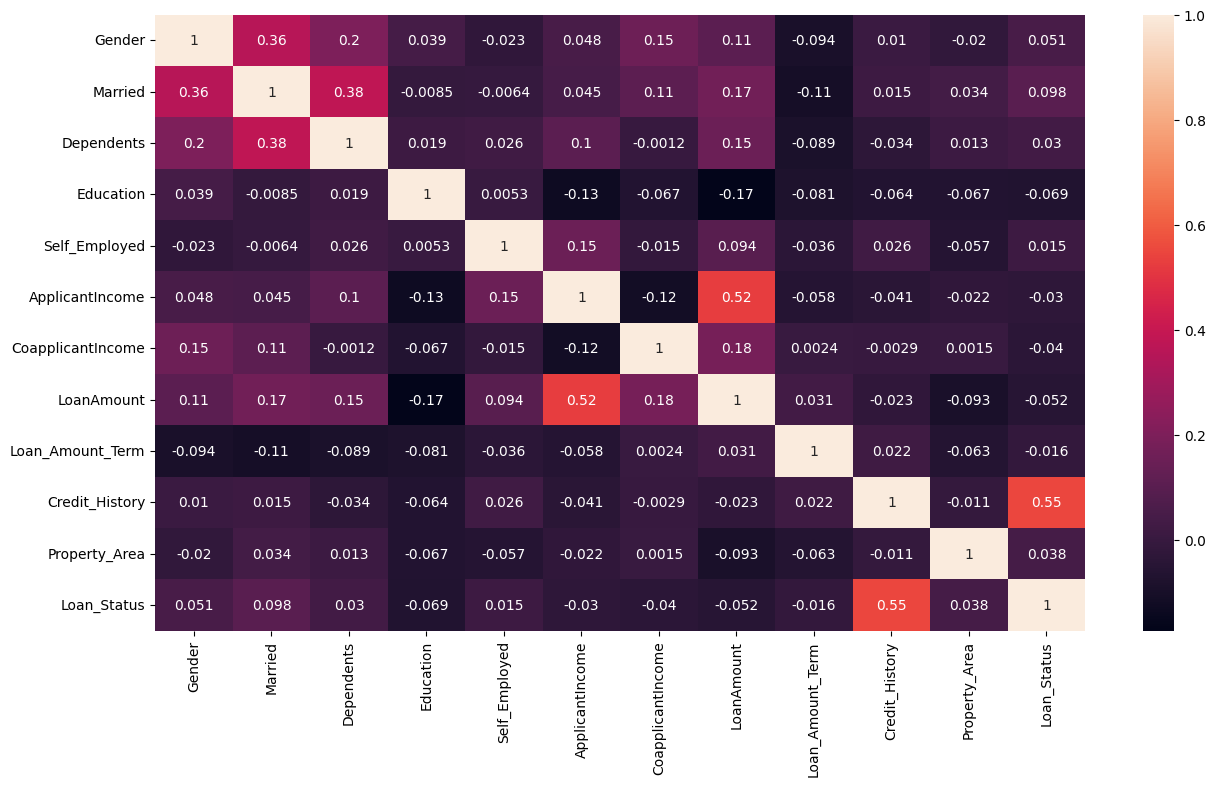

In [13]:
# corr = data_clean.corr()
plt.figure(figsize= (15,8))
sns.heatmap(data_clean.corr(), annot=True, )
plt.show()

The above heatmap is saying hte Applicantincome and credit_history has high impact on Loan_Status.

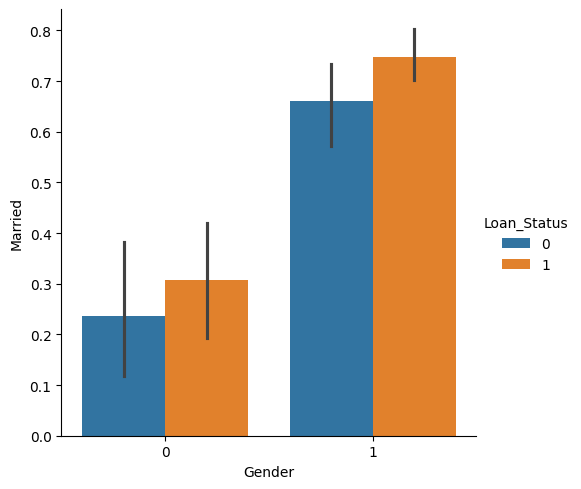

In [14]:
sns.catplot(x='Gender', y='Married',hue = "Loan_Status", kind="bar", data =data)

Marital and Gender Status: Prople who are married has more loans registered in their names.

---

Splitting Dataset and using ML Algorithms

In [15]:
from sklearn.model_selection import train_test_split

X = data_clean.drop(['Loan_Status'], axis=1)
Y = data_clean['Loan_Status']
print(X.shape, Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(518, 11) (518,)


((310, 11), (208, 11), (310,), (208,))

Data has been split successfully.

---

EDA2 Process:
Model Training and Evaluation

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
rfc = RandomForestClassifier(n_estimators=7, criterion='entropy',random_state=5)
scv = SVC()
lc = LogisticRegression()

for clf in (knn, rfc, scv, lc):
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_train)
  print(f"Accuracy Score of {clf.__class__.__name__} = {100*accuracy_score(y_train, y_pred)}")

Accuracy Score of KNeighborsClassifier = 79.03225806451613
Accuracy Score of RandomForestClassifier = 98.06451612903226
Accuracy Score of SVC = 70.3225806451613
Accuracy Score of LogisticRegression = 81.93548387096774


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
#making predictions on the testing sets
for clf in (knn, rfc, scv, lc):
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print(f'Accuracy score of {clf.__class__.__name__} = {100*accuracy_score(y_test, y_pred)}')

Accuracy score of KNeighborsClassifier = 61.057692307692314
Accuracy score of RandomForestClassifier = 75.96153846153845
Accuracy score of SVC = 69.23076923076923
Accuracy score of LogisticRegression = 81.73076923076923


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In CONCLUSION : Logisting Regression is giving the best accuracy with an accuracy score of 81.73, so we can say it's a good model.

We can increase it's accuracy by using methoods like boosting and bagging.

Thank you for going through my work till the end, feel free to reach out if you have any questions.   :)